# Лабораторная работа 3. Свёрточные сети

#### Задание 1.
Построить свёрточную сеть LeNet-5 и обучить её распознаванию MNIST.

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


class LeNet5(nn.Module):
    def __init__(self, conv_layers, activation_fn, pooling_fn = 'max'):
        super().__init__()
        
        self.activation_fn = activation_fn
        self.pooling_fn = pooling_fn

        self.conv_layers = nn.Sequential()
        in_channels = 1
        
        for out_channels, kernel_size, padding in conv_layers[:-1]:
            self.conv_layers.add_module(
                f'conv_{len(self.conv_layers) + 1}',
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
            )
            self.conv_layers.add_module(f'act_{len(self.conv_layers)}', self.activation_fn)
            if self.pooling_fn == 'max':
                self.conv_layers.add_module(f'pool_{len(self.conv_layers)}', nn.MaxPool2d(kernel_size=2))
            elif self.pooling_fn == 'average':
                self.conv_layers.add_module(f'pool_{len(self.conv_layers)}', nn.AvgPool2d(kernel_size=2))
            in_channels = out_channels

        last_out_channels, last_kernel_size, last_padding = conv_layers[-1]
        self.conv_layers.add_module('conv_last', nn.Conv2d(in_channels, last_out_channels, kernel_size=last_kernel_size, padding=last_padding))
        self.conv_layers.add_module('act_last', self.activation_fn)

        self.num_features = None
        self.fc1 = None
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        
        if self.num_features is None:
            self.num_features = torch.numel(x) // x.shape[0]
            self.fc1 = nn.Linear(self.num_features, 84).to(x.device)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        return x

In [32]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        return image, label

In [33]:
def train_model(model, train_dataset, val_dataset, batch_size, num_epochs, optimizer, device):

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False)

    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        losses = []

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        accuracies = []

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            accuracies.append((predicted == labels).sum().item() / len(labels))

    print(f'Accuracy on the val dataset: {np.mean(accuracies):.3f}')
    return np.mean(accuracies)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.ToTensor())

In [35]:
learning_rate = 0.1
momentum = 0.9

num_epochs = 20
batch_size = 100

conv_layers = [
    (6, 5, 2),
    (16, 5, 0),
    (120, 5, 0)
]

In [36]:
model = LeNet5(conv_layers, nn.Tanh(), 'average')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
train_model(model, train_dataset, test_dataset, batch_size, num_epochs, optimizer, device)

Accuracy on the val dataset: 0.991


0.9908000000000001

#### Задание 2.
Поэкспериментировать с параметрами LeNet-5 и найти оптимальную архитектуру для MNIST.  

Параметры для подбора:
- количество свёрточных слоев
- функция активации (Tanh, ReLU)
- способ субдискретизации (Average, Max)
- размер фильтров
- количество фильтров

In [37]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [38]:
for activation_fn in [nn.Tanh(), nn.ReLU()]:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = LeNet5(conv_layers, activation_fn, 'average')
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, batch_size, num_epochs, optimizer, device)
        accuracies.append(acc)
    print(f'Activation function: {activation_fn.__class__.__name__}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.985
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.988
Activation function: Tanh, mean accuracy: 0.987
Accuracy on the val dataset: 0.936
Accuracy on the val dataset: 0.919
Accuracy on the val dataset: 0.941
Activation function: ReLU, mean accuracy: 0.932


In [39]:
activation_fn = nn.Tanh()

In [40]:
for pooling_fn in ['max', 'average']:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = LeNet5(conv_layers, activation_fn, pooling_fn)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, batch_size, num_epochs, optimizer, device)
        accuracies.append(acc)
    print(f'Pooling function: {pooling_fn}, mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on the val dataset: 0.984
Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.978
Pooling function: max, mean accuracy: 0.979
Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.988
Pooling function: average, mean accuracy: 0.987


In [41]:
pooling_fn = 'average'

In [42]:
conv_layers_variants = [
    #kernel size = 3, layers = 2:
    [
        (32, 3, 0),
        (64, 3, 0)
    ],
    [
        (64, 3, 0),
        (128, 3, 0)
    ],
    [
        (128, 3, 0),
        (256, 3, 0)
    ],
    [
        (256, 3, 0),
        (512, 3, 0)
    ],
    [
        (512, 3, 0),
        (1024, 3, 0)
    ],
    
    #kernel size = 3, layers = 3:
    [
        (6, 3, 0),
        (16, 3, 0),
        (120, 3, 0)
    ],
    [
        (12, 3, 0),
        (32, 3, 0),
        (160, 3, 0)
    ],
    [
        (18, 3, 0),
        (48, 3, 0),
        (200, 3, 0)
    ],
    [
        (24, 3, 0),
        (64, 3, 0),
        (240, 3, 0)
    ],
    [
        (30, 3, 0),
        (80, 3, 0),
        (280, 3, 0)
    ],
    
    #kernel size = 3 (last = 5), layers = 3:
    [
        (6, 3, 0),
        (16, 3, 0),
        (120, 5, 0)
    ],
    [
        (12, 3, 0),
        (32, 3, 0),
        (160, 5, 0)
    ],
    [
        (18, 3, 0),
        (48, 3, 0),
        (200, 5, 0)
    ],
    [
        (24, 3, 0),
        (64, 3, 0),
        (240, 5, 0)
    ],
    [
        (30, 3, 0),
        (80, 3, 0),
        (280, 5, 0)
    ],
    
    #kernel size = 3, layers = 4:
    [
        (6, 3, 1),
        (16, 3, 1),
        (32, 3, 1),
        (120, 3, 0)
    ],
    [
        (12, 3, 1),
        (32, 3, 1),
        (64, 3, 1),
        (160, 3, 0)
    ],
    [
        (18, 3, 1),
        (48, 3, 1),
        (96, 3, 1),
        (200, 3, 0)
    ],
    [
        (24, 3, 1),
        (64, 3, 1),
        (128, 3, 1),
        (240, 3, 0)
    ],
    [
        (30, 3, 1),
        (80, 3, 1),
        (160, 3, 1),
        (280, 3, 0)
    ],
    
    #kernel size = 5, layers = 2:
    [
        (32, 5, 0),
        (64, 5, 0)
    ],
    [
        (64, 5, 0),
        (128, 5, 0)
    ],
    [
        (128, 5, 0),
        (256, 5, 0)
    ],
    [
        (256, 5, 0),
        (512, 5, 0)
    ],
    [
        (512, 5, 0),
        (1024, 5, 0)
    ],
    
    #kernel size = 5, layers = 3:
    [
        (6, 5, 2),
        (16, 5, 0),
        (120, 5, 0)
    ],
    [
        (12, 5, 2),
        (32, 5, 0),
        (160, 5, 0)
    ],
    [
        (18, 5, 2),
        (48, 5, 0),
        (200, 5, 0)
    ],
    [
        (24, 5, 2),
        (64, 5, 0),
        (240, 5, 0)
    ],
    [
        (30, 5, 2),
        (80, 5, 0),
        (280, 5, 0)
    ],
    
    #kernel size = 5 (last = 3), layers = 4:
    [
        (6, 5, 2),
        (16, 5, 2),
        (32, 5, 2),
        (120, 3, 0)
    ],
    [
        (12, 5, 2),
        (32, 5, 2),
        (64, 5, 2),
        (160, 3, 0)
    ],
    [
        (18, 5, 2),
        (48, 5, 2),
        (96, 5, 2),
        (200, 3, 0)
    ],
    [
        (24, 5, 2),
        (64, 5, 2),
        (128, 5, 2),
        (240, 3, 0)
    ],
    [
        (30, 5, 2),
        (80, 5, 2),
        (160, 5, 2),
        (280, 3, 0)
    ],
    
    #kernel size = 7, layers = 2:
    [
        (32, 7, 0),
        (64, 7, 0)
    ],
    [
        (64, 7, 0),
        (128, 7, 0)
    ],
    [
        (128, 7, 0),
        (256, 7, 0)
    ],
    [
        (256, 7, 0),
        (512, 7, 0)
    ],
    [
        (512, 7, 0),
        (1024, 7, 0)
    ],
    
    #kernel size = 7, layers = 3, last without padding:
    [
        (6, 7, 3),
        (16, 7, 3),
        (120, 7, 0)
    ],
    [
        (12, 7, 3),
        (32, 7, 3),
        (160, 7, 0)
    ],
    [
        (18, 7, 3),
        (48, 7, 3),
        (200, 7, 0)
    ],
    [
        (24, 7, 3),
        (64, 7, 3),
        (240, 7, 0)
    ],
    [
        (30, 7, 3),
        (80, 7, 3),
        (280, 7, 0)
    ],
    
    #kernel size = 7, layers = 3, last with padding:
    [
        (6, 7, 3),
        (16, 7, 3),
        (120, 7, 3)
    ],
    [
        (12, 7, 3),
        (32, 7, 3),
        (160, 7, 3)
    ],
    [
        (18, 7, 3),
        (48, 7, 3),
        (200, 7, 3)
    ],
    [
        (24, 7, 3),
        (64, 7, 3),
        (240, 7, 3)
    ],
    [
        (30, 7, 3),
        (80, 7, 3),
        (280, 7, 3)
    ],
    
    #kernel size = 7 (last = 3), layers = 4:
    [
        (6, 7, 3),
        (16, 7, 3),
        (32, 7, 3),
        (120, 3, 0)
    ],
    [
        (12, 7, 3),
        (32, 7, 3),
        (64, 7, 3),
        (160, 3, 0)
    ],
    [
        (18, 7, 3),
        (48, 7, 3),
        (96, 7, 3),
        (200, 3, 0)
    ],
    [
        (24, 7, 3),
        (64, 7, 3),
        (128, 7, 3),
        (240, 3, 0)
    ],
    [
        (30, 7, 3),
        (80, 7, 3),
        (160, 7, 3),
        (280, 3, 0)
    ],
]

In [43]:
len(conv_layers_variants)

55

In [44]:
import pandas as pd

conv_layers_stats_df = pd.DataFrame(data=None, columns=['conv_layers', 'accuracy'])
conv_layers_stats_df_index = 0

def append_conv_layers_stats(conv_layers, accuracy):
    global conv_layers_stats_df_index
    conv_layers_stats_df.loc[conv_layers_stats_df_index] = [conv_layers, accuracy]
    conv_layers_stats_df_index += 1

In [45]:
for conv_layers in conv_layers_variants:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[train_index], transforms.ToTensor())
        
        model = LeNet5(conv_layers, activation_fn, pooling_fn)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, batch_size, num_epochs, optimizer, device)
        accuracies.append(acc)
    print(f'Conv layers: {conv_layers}, mean accuracy: {np.mean(accuracies):.3f}')
    append_conv_layers_stats(conv_layers, np.mean(accuracies))

Accuracy on the val dataset: 0.976
Accuracy on the val dataset: 0.978
Accuracy on the val dataset: 0.979
Conv layers: [(32, 3, 0), (64, 3, 0)], mean accuracy: 0.978
Accuracy on the val dataset: 0.981
Accuracy on the val dataset: 0.983
Accuracy on the val dataset: 0.981
Conv layers: [(64, 3, 0), (128, 3, 0)], mean accuracy: 0.981
Accuracy on the val dataset: 0.985
Accuracy on the val dataset: 0.986
Accuracy on the val dataset: 0.986
Conv layers: [(128, 3, 0), (256, 3, 0)], mean accuracy: 0.986
Accuracy on the val dataset: 0.986
Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.987
Conv layers: [(256, 3, 0), (512, 3, 0)], mean accuracy: 0.987
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.987
Conv layers: [(512, 3, 0), (1024, 3, 0)], mean accuracy: 0.987
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.987
Conv layers: [(6, 3, 0), (16, 3, 0), (120, 3, 0)], mean accura

C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.988
Conv layers: [(128, 5, 0), (256, 5, 0)], mean accuracy: 0.988


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.988
Conv layers: [(256, 5, 0), (512, 5, 0)], mean accuracy: 0.989
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.988
Conv layers: [(512, 5, 0), (1024, 5, 0)], mean accuracy: 0.988
Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.987
Conv layers: [(6, 5, 2), (16, 5, 0), (120, 5, 0)], mean accuracy: 0.988
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(12, 5, 2), (32, 5, 0), (160, 5, 0)], mean accuracy: 0.989
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.991
Conv layers: [(18, 5, 2), (48, 5, 0), (200, 5, 0)], mean accuracy: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.990
Conv layers: [(24, 5, 2), (

C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.980
Accuracy on the val dataset: 0.977
Accuracy on the val dataset: 0.979
Conv layers: [(32, 7, 0), (64, 7, 0)], mean accuracy: 0.979
Accuracy on the val dataset: 0.983
Accuracy on the val dataset: 0.984
Accuracy on the val dataset: 0.983
Conv layers: [(64, 7, 0), (128, 7, 0)], mean accuracy: 0.983


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.986
Conv layers: [(128, 7, 0), (256, 7, 0)], mean accuracy: 0.987


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.987
Conv layers: [(256, 7, 0), (512, 7, 0)], mean accuracy: 0.988


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


KeyboardInterrupt: 

In [46]:
conv_layers_variants = [
    #kernel size = 7, layers = 3, last without padding:
    [
        (6, 7, 3),
        (16, 7, 3),
        (120, 7, 0)
    ],
    [
        (12, 7, 3),
        (32, 7, 3),
        (160, 7, 0)
    ],
    [
        (18, 7, 3),
        (48, 7, 3),
        (200, 7, 0)
    ],
    [
        (24, 7, 3),
        (64, 7, 3),
        (240, 7, 0)
    ],
    [
        (30, 7, 3),
        (80, 7, 3),
        (280, 7, 0)
    ],

    #kernel size = 7, layers = 3, last with padding:
    [
        (6, 7, 3),
        (16, 7, 3),
        (120, 7, 3)
    ],
    [
        (12, 7, 3),
        (32, 7, 3),
        (160, 7, 3)
    ],
    [
        (18, 7, 3),
        (48, 7, 3),
        (200, 7, 3)
    ],
    [
        (24, 7, 3),
        (64, 7, 3),
        (240, 7, 3)
    ],
    [
        (30, 7, 3),
        (80, 7, 3),
        (280, 7, 3)
    ],

    #kernel size = 7 (last = 3), layers = 4:
    [
        (6, 7, 3),
        (16, 7, 3),
        (32, 7, 3),
        (120, 3, 0)
    ],
    [
        (12, 7, 3),
        (32, 7, 3),
        (64, 7, 3),
        (160, 3, 0)
    ],
    [
        (18, 7, 3),
        (48, 7, 3),
        (96, 7, 3),
        (200, 3, 0)
    ],
    [
        (24, 7, 3),
        (64, 7, 3),
        (128, 7, 3),
        (240, 3, 0)
    ],
    [
        (30, 7, 3),
        (80, 7, 3),
        (160, 7, 3),
        (280, 3, 0)
    ],
]

In [47]:
for conv_layers in conv_layers_variants:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[train_index], transforms.ToTensor())

        model = LeNet5(conv_layers, activation_fn, pooling_fn)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, batch_size, num_epochs, optimizer, device)
        accuracies.append(acc)
    print(f'Conv layers: {conv_layers}, mean accuracy: {np.mean(accuracies):.3f}')
    append_conv_layers_stats(conv_layers, np.mean(accuracies))

C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy on the val dataset: 0.986
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.986
Conv layers: [(6, 7, 3), (16, 7, 3), (120, 7, 0)], mean accuracy: 0.986


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.989
Conv layers: [(12, 7, 3), (32, 7, 3), (160, 7, 0)], mean accuracy: 0.989


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.989
Conv layers: [(18, 7, 3), (48, 7, 3), (200, 7, 0)], mean accuracy: 0.990


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.989
Conv layers: [(24, 7, 3), (64, 7, 3), (240, 7, 0)], mean accuracy: 0.990


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(30, 7, 3), (80, 7, 3), (280, 7, 0)], mean accuracy: 0.990
Accuracy on the val dataset: 0.988
Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.987
Conv layers: [(6, 7, 3), (16, 7, 3), (120, 7, 3)], mean accuracy: 0.988


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.989
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(12, 7, 3), (32, 7, 3), (160, 7, 3)], mean accuracy: 0.990


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(18, 7, 3), (48, 7, 3), (200, 7, 3)], mean accuracy: 0.990


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(24, 7, 3), (64, 7, 3), (240, 7, 3)], mean accuracy: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(30, 7, 3), (80, 7, 3), (280, 7, 3)], mean accuracy: 0.990
Accuracy on the val dataset: 0.987
Accuracy on the val dataset: 0.986
Accuracy on the val dataset: 0.984
Conv layers: [(6, 7, 3), (16, 7, 3), (32, 7, 3), (120, 3, 0)], mean accuracy: 0.986
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(12, 7, 3), (32, 7, 3), (64, 7, 3), (160, 3, 0)], mean accuracy: 0.990
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.990
Conv layers: [(18, 7, 3), (48, 7, 3), (96, 7, 3), (200, 3, 0)], mean accuracy: 0.990


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.990
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.991
Conv layers: [(24, 7, 3), (64, 7, 3), (128, 7, 3), (240, 3, 0)], mean accuracy: 0.991


C:\Users\bred7\anaconda3\envs\vyatsu_environment\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.991
Conv layers: [(30, 7, 3), (80, 7, 3), (160, 7, 3), (280, 3, 0)], mean accuracy: 0.991


In [48]:
conv_layers_stats_df.to_csv("conv_layers_stats.csv", index=False)

In [49]:
conv_layers_variants = [
    [(30, 3, 1), (80, 3, 1), (160, 3, 1), (280, 3, 0)],
    [(40, 3, 1), (100, 3, 1), (200, 3, 1), (320, 3, 0)],
    [(50, 3, 1), (120, 3, 1), (240, 3, 1), (360, 3, 0)],
    [(60, 3, 1), (140, 3, 1), (280, 3, 1), (400, 3, 0)],
    [(70, 3, 1), (160, 3, 1), (320, 3, 1), (440, 3, 0)],
    [(80, 3, 1), (180, 3, 1), (360, 3, 1), (480, 3, 0)],
    [(90, 3, 1), (200, 3, 1), (400, 3, 1), (520, 3, 0)],
    [(100, 3, 1), (220, 3, 1), (440, 3, 1), (560, 3, 0)],
    [(110, 3, 1), (240, 3, 1), (480, 3, 1), (600, 3, 0)],
    [(120, 3, 1), (260, 3, 1), (520, 3, 1), (640, 3, 0)],
    [(130, 3, 1), (280, 3, 1), (560, 3, 1), (680, 3, 0)],
    [(140, 3, 1), (300, 3, 1), (600, 3, 1), (720, 3, 0)],
    [(150, 3, 1), (320, 3, 1), (640, 3, 1), (760, 3, 0)],
    [(160, 3, 1), (340, 3, 1), (680, 3, 1), (800, 3, 0)],
    [(170, 3, 1), (360, 3, 1), (720, 3, 1), (840, 3, 0)],
    [(180, 3, 1), (380, 3, 1), (760, 3, 1), (880, 3, 0)],
    [(190, 3, 1), (400, 3, 1), (800, 3, 1), (920, 3, 0)],
    [(200, 3, 1), (420, 3, 1), (840, 3, 1), (960, 3, 0)],
    [(210, 3, 1), (440, 3, 1), (880, 3, 1), (1000, 3, 0)]
]

In [50]:
for conv_layers in conv_layers_variants:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[train_index], transforms.ToTensor())

        model = LeNet5(conv_layers, activation_fn, pooling_fn)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, batch_size, num_epochs, optimizer, device)
        accuracies.append(acc)
    print(f'Conv layers: {conv_layers}, mean accuracy: {np.mean(accuracies):.5f}')
    append_conv_layers_stats(conv_layers, np.mean(accuracies))

Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.992
Conv layers: [(30, 3, 1), (80, 3, 1), (160, 3, 1), (280, 3, 0)], mean accuracy: 0.99147
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Conv layers: [(40, 3, 1), (100, 3, 1), (200, 3, 1), (320, 3, 0)], mean accuracy: 0.99177
Accuracy on the val dataset: 0.993
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.992
Conv layers: [(50, 3, 1), (120, 3, 1), (240, 3, 1), (360, 3, 0)], mean accuracy: 0.99185
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.991
Accuracy on the val dataset: 0.992
Conv layers: [(60, 3, 1), (140, 3, 1), (280, 3, 1), (400, 3, 0)], mean accuracy: 0.99152
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Conv layers: [(70, 3, 1), (160, 3, 1), (320, 3, 1), (440, 3, 0)], mean accuracy: 0.99193
Accuracy on the val dataset: 0.

KeyboardInterrupt: 

In [51]:
conv_layers_stats_df.to_csv("conv_layers_stats_2.csv", index=False)

In [52]:
conv_layers_variants = [
    [(200, 3, 1), (420, 3, 1), (840, 3, 1), (960, 3, 0)],
    [(210, 3, 1), (440, 3, 1), (880, 3, 1), (1000, 3, 0)],
    [(220, 3, 1), (460, 3, 1), (920, 3, 1), (1040, 3, 0)],
    [(230, 3, 1), (480, 3, 1), (960, 3, 1), (1080, 3, 0)],
    [(240, 3, 1), (500, 3, 1), (1000, 3, 1), (1120, 3, 0)],
    [(250, 3, 1), (520, 3, 1), (1040, 3, 1), (1160, 3, 0)],
    [(260, 3, 1), (540, 3, 1), (1080, 3, 1), (1200, 3, 0)],
    [(270, 3, 1), (560, 3, 1), (1120, 3, 1), (1240, 3, 0)],
    [(280, 3, 1), (580, 3, 1), (1160, 3, 1), (1280, 3, 0)],
    [(290, 3, 1), (600, 3, 1), (1200, 3, 1), (1320, 3, 0)],
    [(300, 3, 1), (620, 3, 1), (1240, 3, 1), (1360, 3, 0)],
    [(310, 3, 1), (640, 3, 1), (1280, 3, 1), (1400, 3, 0)],
    [(320, 3, 1), (660, 3, 1), (1320, 3, 1), (1440, 3, 0)],
    [(330, 3, 1), (680, 3, 1), (1360, 3, 1), (1480, 3, 0)],
    [(340, 3, 1), (700, 3, 1), (1400, 3, 1), (1520, 3, 0)],
    [(350, 3, 1), (720, 3, 1), (1440, 3, 1), (1560, 3, 0)],
    [(360, 3, 1), (740, 3, 1), (1480, 3, 1), (1600, 3, 0)],
    [(370, 3, 1), (760, 3, 1), (1520, 3, 1), (1640, 3, 0)],
    [(380, 3, 1), (780, 3, 1), (1560, 3, 1), (1680, 3, 0)],
    [(390, 3, 1), (800, 3, 1), (1600, 3, 1), (1720, 3, 0)],
    [(400, 3, 1), (820, 3, 1), (1640, 3, 1), (1760, 3, 0)],
]

In [53]:
for conv_layers in conv_layers_variants:
    accuracies = []
    for train_index, val_index in kfold.split(train_dataset):
        val = MNISTDataset(train_dataset.data[val_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[val_index], transforms.ToTensor())
        train = MNISTDataset(train_dataset.data[train_index].to(dtype=torch.float32).unsqueeze(1), train_dataset.targets[train_index], transforms.ToTensor())

        model = LeNet5(conv_layers, activation_fn, pooling_fn)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
        acc = train_model(model, train, val, batch_size, num_epochs, optimizer, device)
        accuracies.append(acc)
    print(f'Conv layers: {conv_layers}, mean accuracy: {np.mean(accuracies):.5f}')
    append_conv_layers_stats(conv_layers, np.mean(accuracies))

Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Conv layers: [(200, 3, 1), (420, 3, 1), (840, 3, 1), (960, 3, 0)], mean accuracy: 0.99200
Accuracy on the val dataset: 0.993
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Conv layers: [(210, 3, 1), (440, 3, 1), (880, 3, 1), (1000, 3, 0)], mean accuracy: 0.99198
Accuracy on the val dataset: 0.993
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.993
Conv layers: [(220, 3, 1), (460, 3, 1), (920, 3, 1), (1040, 3, 0)], mean accuracy: 0.99243
Accuracy on the val dataset: 0.993
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.993
Conv layers: [(230, 3, 1), (480, 3, 1), (960, 3, 1), (1080, 3, 0)], mean accuracy: 0.99243
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Accuracy on the val dataset: 0.992
Conv layers: [(240, 3, 1), (500, 3, 1), (1000, 3, 1), (1120, 3, 0)], mean accuracy: 0.99225
Accuracy on the val 

KeyboardInterrupt: 

In [54]:
conv_layers_stats_df.to_csv("conv_layers_stats_3.csv", index=False)

In [119]:
conv_layers_variants = [
    [(280, 3, 1), (580, 3, 1), (1160, 3, 1), (1280, 3, 0)],
    [(320, 3, 1), (660, 3, 1), (1320, 3, 1), (1440, 3, 0)],
    [(250, 3, 1), (520, 3, 1), (1040, 3, 1), (1160, 3, 0)],
    [(220, 3, 1), (460, 3, 1), (920, 3, 1), (1040, 3, 0)],
    [(230, 3, 1), (480, 3, 1), (960, 3, 1), (1080, 3, 0)],
    [(330, 3, 1), (680, 3, 1), (1360, 3, 1), (1480, 3, 0)],
    [(180, 3, 1), (380, 3, 1), (760, 3, 1), (880, 3, 0)],
    [(340, 3, 1), (700, 3, 1), (1400, 3, 1), (1520, 3, 0)],
    [(190, 3, 1), (400, 3, 1), (800, 3, 1), (920, 3, 0)],
    [(150, 3, 1), (320, 3, 1), (640, 3, 1), (760, 3, 0)],
    [(170, 3, 1), (360, 3, 1), (720, 3, 1), (840, 3, 0)],
    [(260, 3, 1), (540, 3, 1), (1080, 3, 1), (1200, 3, 0)],
    [(240, 3, 1), (500, 3, 1), (1000, 3, 1), (1120, 3, 0)],
    [(290, 3, 1), (600, 3, 1), (1200, 3, 1), (1320, 3, 0)],
    [(270, 3, 1), (560, 3, 1), (1120, 3, 1), (1240, 3, 0)],
    [(90, 3, 1), (200, 3, 1), (400, 3, 1), (520, 3, 0)],
    [(140, 3, 1), (300, 3, 1), (600, 3, 1), (720, 3, 0)],
    [(310, 3, 1), (640, 3, 1), (1280, 3, 1), (1400, 3, 0)],
    [(160, 3, 1), (340, 3, 1), (680, 3, 1), (800, 3, 0)],
    [(110, 3, 1), (240, 3, 1), (480, 3, 1), (600, 3, 0)],
    [(80, 3, 1), (180, 3, 1), (360, 3, 1), (480, 3, 0)],
    [(200, 3, 1), (420, 3, 1), (840, 3, 1), (960, 3, 0)],
    [(210, 3, 1), (440, 3, 1), (880, 3, 1), (1000, 3, 0)],
    [(130, 3, 1), (280, 3, 1), (560, 3, 1), (680, 3, 0)],
    [(70, 3, 1), (160, 3, 1), (320, 3, 1), (440, 3, 0)],
    [(300, 3, 1), (620, 3, 1), (1240, 3, 1), (1360, 3, 0)],
    [(100, 3, 1), (220, 3, 1), (440, 3, 1), (560, 3, 0)],
    [(50, 3, 1), (120, 3, 1), (240, 3, 1), (360, 3, 0)],
    [(120, 3, 1), (260, 3, 1), (520, 3, 1), (640, 3, 0)],
    [(40, 3, 1), (100, 3, 1), (200, 3, 1), (320, 3, 0)],
]

In [120]:
conv_layers_stats_df = pd.DataFrame(data=None, columns=['conv_layers', 'accuracy'])
conv_layers_stats_df_index = 0

def append_conv_layers_stats(conv_layers, accuracy):
    global conv_layers_stats_df_index
    conv_layers_stats_df.loc[conv_layers_stats_df_index] = [conv_layers, accuracy]
    conv_layers_stats_df_index += 1

In [121]:
for conv_layers in conv_layers_variants:
    model = LeNet5(conv_layers, activation_fn, pooling_fn)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
    acc = train_model(model, train_dataset, test_dataset, batch_size, num_epochs, optimizer, device)
    print(f'Conv layers: {conv_layers}, accuracy: {acc:.5f}')
    append_conv_layers_stats(conv_layers, acc)

conv_layers_stats_df.to_csv("conv_layers_stats_test.csv", index=False)

Accuracy on the val dataset: 0.991
Conv layers: [(280, 3, 1), (580, 3, 1), (1160, 3, 1), (1280, 3, 0)], accuracy: 0.99110
Accuracy on the val dataset: 0.991
Conv layers: [(320, 3, 1), (660, 3, 1), (1320, 3, 1), (1440, 3, 0)], accuracy: 0.99090
Accuracy on the val dataset: 0.992
Conv layers: [(250, 3, 1), (520, 3, 1), (1040, 3, 1), (1160, 3, 0)], accuracy: 0.99150
Accuracy on the val dataset: 0.991
Conv layers: [(220, 3, 1), (460, 3, 1), (920, 3, 1), (1040, 3, 0)], accuracy: 0.99120
Accuracy on the val dataset: 0.990
Conv layers: [(230, 3, 1), (480, 3, 1), (960, 3, 1), (1080, 3, 0)], accuracy: 0.99030
Accuracy on the val dataset: 0.991
Conv layers: [(330, 3, 1), (680, 3, 1), (1360, 3, 1), (1480, 3, 0)], accuracy: 0.99100
Accuracy on the val dataset: 0.991
Conv layers: [(180, 3, 1), (380, 3, 1), (760, 3, 1), (880, 3, 0)], accuracy: 0.99130
Accuracy on the val dataset: 0.991
Conv layers: [(340, 3, 1), (700, 3, 1), (1400, 3, 1), (1520, 3, 0)], accuracy: 0.99090
Accuracy on the val dataset:

In [142]:
conv_layers = [(210, 3, 1), (440, 3, 1), (880, 3, 1), (1000, 3, 0)]
model = LeNet5(conv_layers, activation_fn, pooling_fn)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
acc = train_model(model, train_dataset, test_dataset, batch_size, num_epochs, optimizer, device)

Accuracy on the val dataset: 0.992


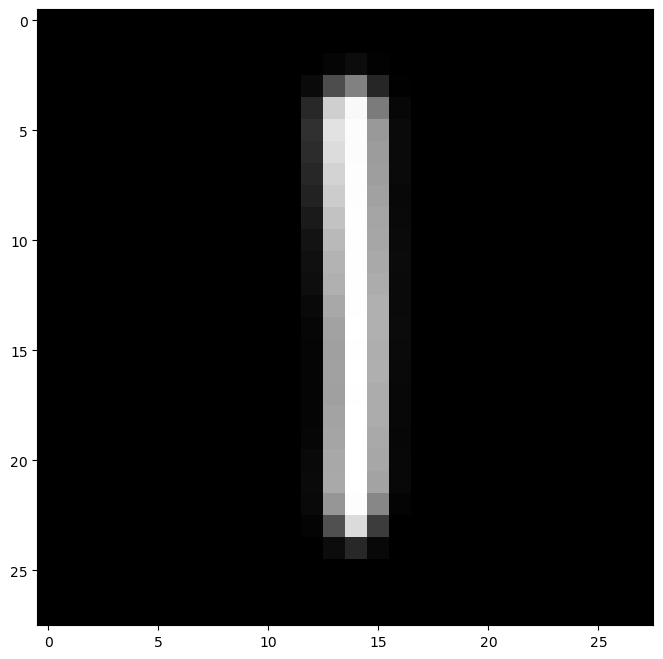

In [143]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('one.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [144]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 1


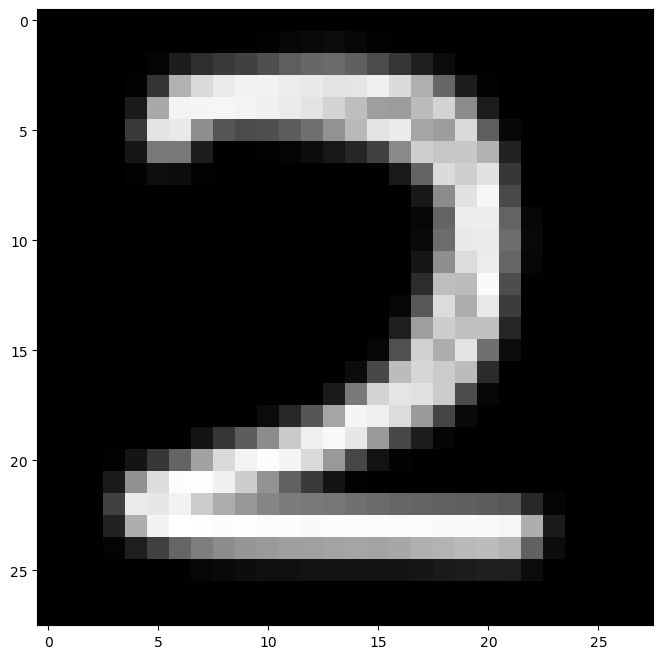

In [145]:
img = cv2.imread('two.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [146]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 2


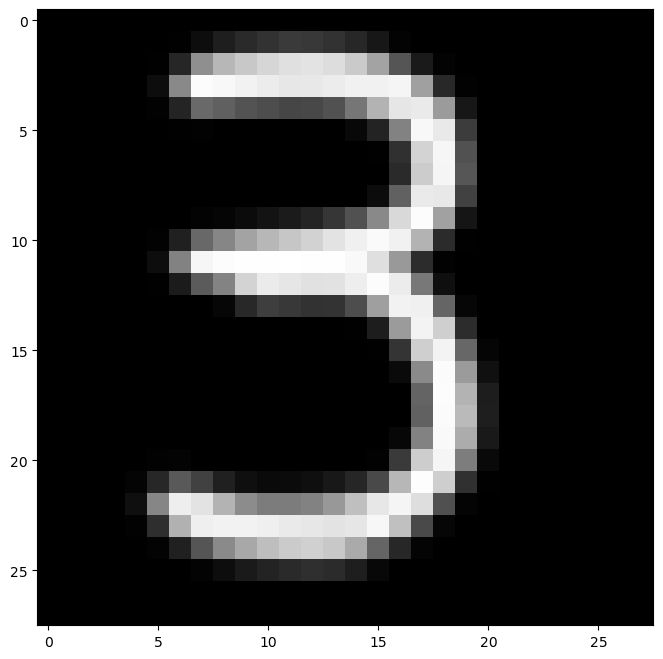

In [147]:
img = cv2.imread('three.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [148]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 3


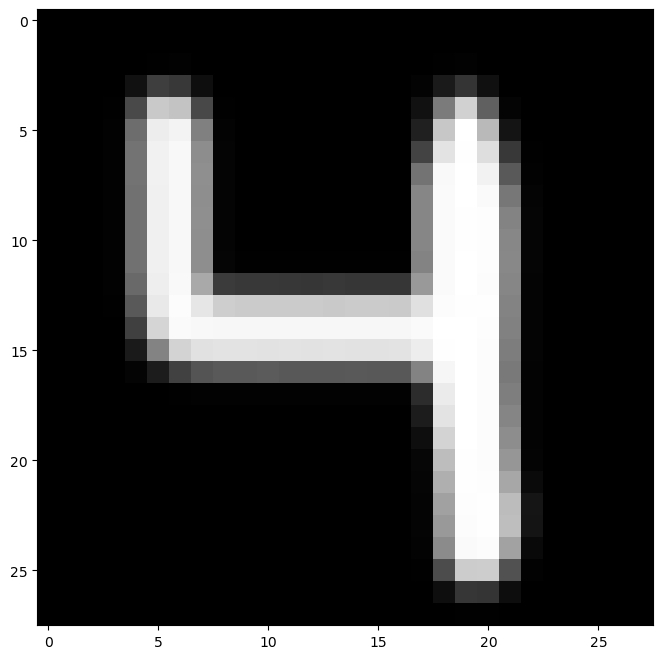

In [149]:
img = cv2.imread('four.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [150]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 4


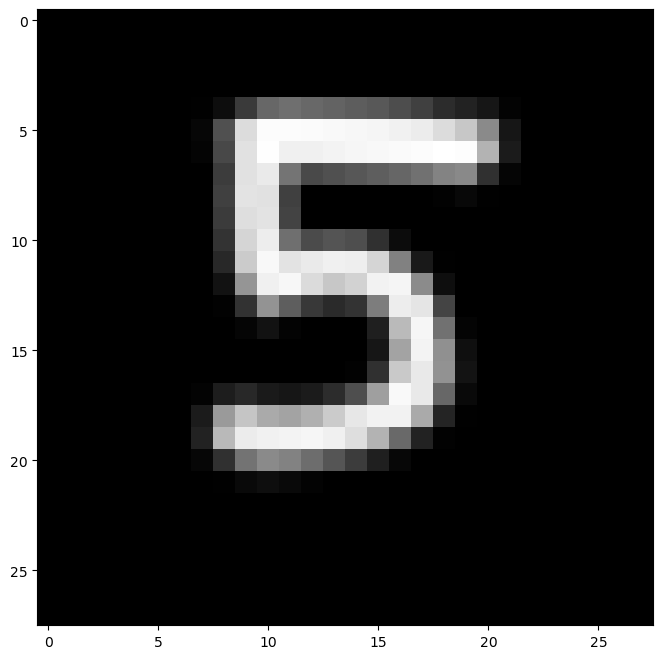

In [151]:
img = cv2.imread('five.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [152]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 5


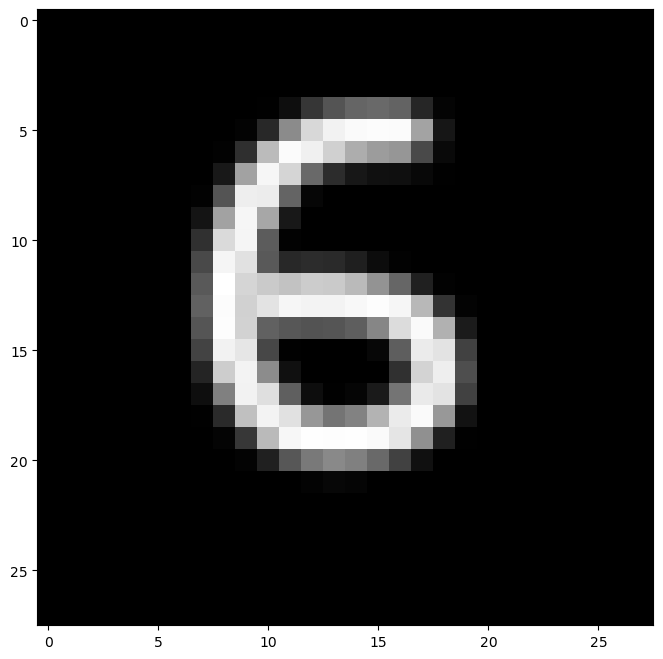

In [153]:
img = cv2.imread('six.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [154]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 6


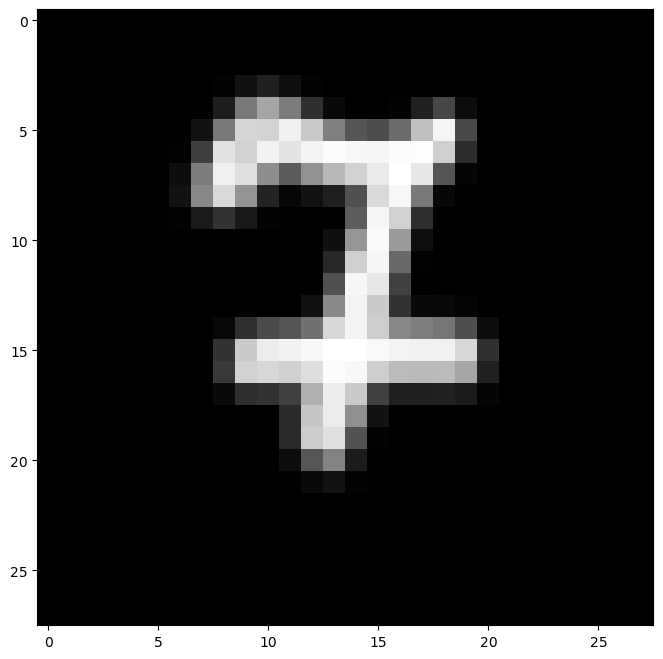

In [155]:
img = cv2.imread('seven.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [156]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 7


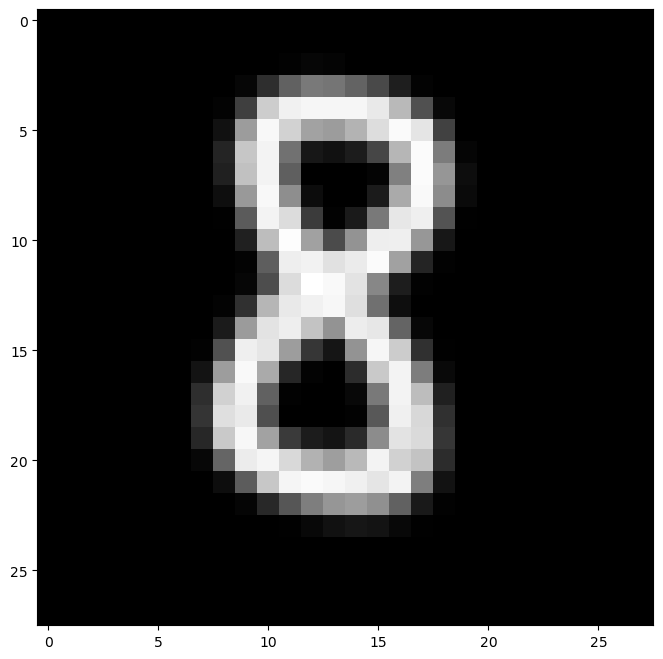

In [157]:
img = cv2.imread('eight.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [158]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 8


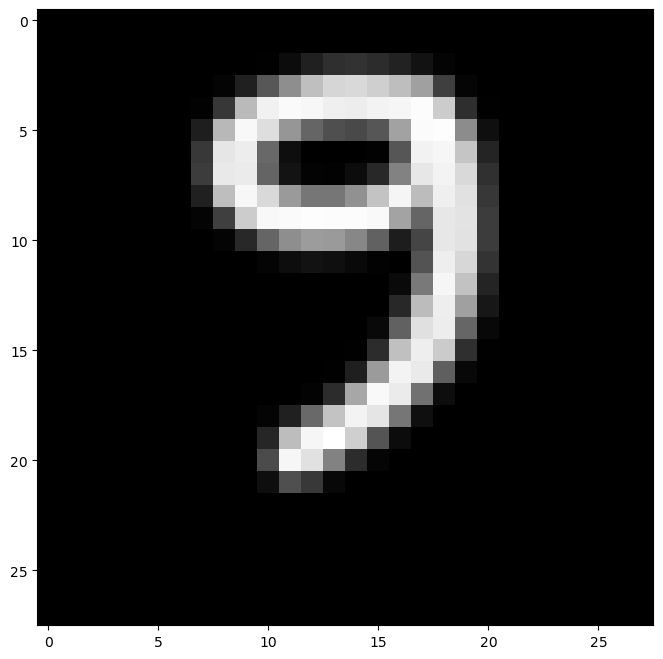

In [159]:
img = cv2.imread('nine.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [160]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 3


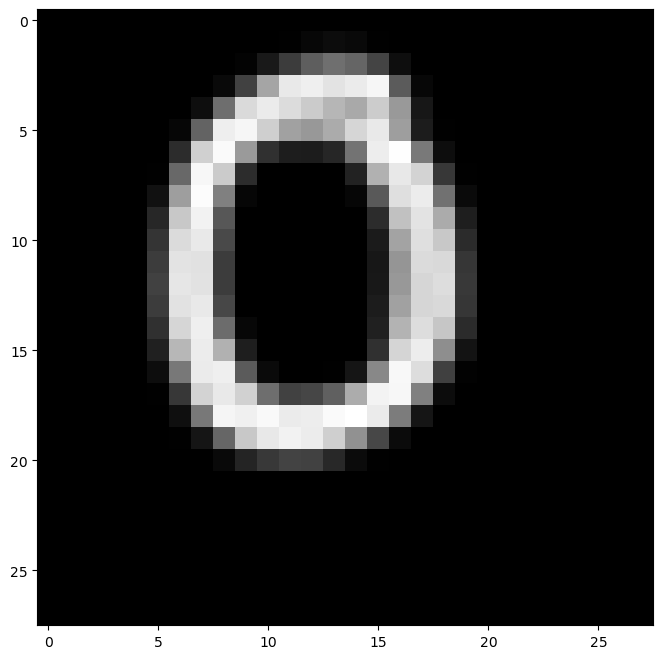

In [161]:
img = cv2.imread('zero.png', cv2.IMREAD_GRAYSCALE)
figure = plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [162]:
with torch.no_grad():
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    output = model(img)
    predicted = torch.argmax(output, 1)
    print(f'Predicted: {predicted.item()}')

Predicted: 0


In [ ]:
#9 из 10 изображений распознались верно

#### Задание 3 (факультативное).
Построить свёрточную сеть по одной из рассмотренных архитектур (AlexNet, VGG, Inception, ResNet) и обучить её распознаванию MNIST.

#### Задание 4 (факультативное).
Прочитать параграф 5.3 в учебнике С. Николенко и др. (стр. 199–206) и воспроизвести рассмотренные там нейронные сети на TensorFlow и Keras.